# Results and Analysis Part 1: Monet-Style Image Generation

In this notebook, we'll evaluate the performance of our CycleGAN model for generating Monet-style images. This is part 1 of the results analysis, focusing on loading the model and generating Monet-style images.

## 1. Setup and Imports

First, let's import the necessary libraries and set up our environment.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import glob
import random
import zipfile
from PIL import Image
from tqdm.notebook import tqdm
import cv2

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Set plot style - using a style compatible with newer matplotlib versions
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

2025-03-16 20:28:39.685478: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 2. Load Trained Models

Let's load the trained generator model that we created in the previous notebook.

In [2]:
# Define paths
# Check if we're in Kaggle environment
IN_KAGGLE = os.path.exists('/kaggle/input')

if IN_KAGGLE:
    # Kaggle paths
    MONET_JPG_DIR = "/kaggle/input/gan-getting-started/monet_jpg"
    PHOTO_JPG_DIR = "/kaggle/input/gan-getting-started/photo_jpg"
    CHECKPOINT_DIR = "/kaggle/input/monet-cyclegan-checkpoints/training_checkpoints"
else:
    # Local paths - adjust these based on your data location
    BASE_DIR = '../data'
    MONET_JPG_DIR = os.path.join(BASE_DIR, 'monet_jpg')
    PHOTO_JPG_DIR = os.path.join(BASE_DIR, 'photo_jpg')
    CHECKPOINT_DIR = './training_checkpoints'
    
# Output directory for generated images
OUTPUT_DIR = './generated_images'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Check if the paths exist
print(f"Monet JPG directory exists: {os.path.exists(MONET_JPG_DIR)}")
print(f"Photo JPG directory exists: {os.path.exists(PHOTO_JPG_DIR)}")
print(f"Checkpoint directory exists: {os.path.exists(CHECKPOINT_DIR)}")

Monet JPG directory exists: True
Photo JPG directory exists: True
Checkpoint directory exists: True


In [3]:
# Load the generator model
# First, we need to define the model architecture (same as in the previous notebook)

def downsample(filters, size, apply_batchnorm=True):
    """Downsampling block for the generator."""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the generator."""
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                              kernel_initializer=initializer, use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

def build_generator():
    """Build the generator model."""
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    
    # Downsampling
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (128, 128, 64)
        downsample(128, 4),  # (64, 64, 128)
        downsample(256, 4),  # (32, 32, 256)
        downsample(512, 4),  # (16, 16, 512)
    ]
    
    # Upsampling
    up_stack = [
        upsample(256, 4, apply_dropout=True),  # (32, 32, 256)
        upsample(128, 4),  # (64, 64, 128)
        upsample(64, 4),  # (128, 128, 64)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')  # (256, 256, 3)
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    # Upsampling and establishing the skip connections
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [4]:
# Try to load the model from the models directory first
models_dir = '../models'
generator_g = None

if os.path.exists(os.path.join(models_dir, 'generator_g.keras')):
    print("Loading model from models directory...")
    generator_g = tf.keras.models.load_model(os.path.join(models_dir, 'generator_g.keras'))
    print("Model loaded successfully.")
else:
    # If model doesn't exist in models directory, try to load from checkpoint
    print("Model not found in models directory. Trying to load from checkpoint...")
    
    # Create the generator model
    generator_g = build_generator()
    generator_f = build_generator()
    
    # Create a dummy discriminator (needed for checkpoint loading)
    def build_discriminator():
        initializer = tf.random_normal_initializer(0., 0.02)
        inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
        x = downsample(64, 4, apply_batchnorm=False)(inp)
        x = downsample(128, 4)(x)
        x = downsample(256, 4)(x)
        x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same',
                                  kernel_initializer=initializer, use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same',
                                  kernel_initializer=initializer)(x)
        return tf.keras.Model(inputs=inp, outputs=x)
    
    discriminator_x = build_discriminator()
    discriminator_y = build_discriminator()
    
    # Define optimizers (needed for checkpoint loading)
    generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    # Create checkpoint
    checkpoint = tf.train.Checkpoint(
        generator_g=generator_g,
        generator_f=generator_f,
        discriminator_x=discriminator_x,
        discriminator_y=discriminator_y,
        generator_g_optimizer=generator_g_optimizer,
        generator_f_optimizer=generator_f_optimizer,
        discriminator_x_optimizer=discriminator_x_optimizer,
        discriminator_y_optimizer=discriminator_y_optimizer
    )
    
    # Load the latest checkpoint
    if os.path.exists(CHECKPOINT_DIR):
        latest_checkpoint = tf.train.latest_checkpoint(CHECKPOINT_DIR)
        if latest_checkpoint:
            checkpoint.restore(latest_checkpoint)
            print(f"Checkpoint restored: {latest_checkpoint}")
        else:
            print("No checkpoint found.")
    else:
        print(f"Checkpoint directory {CHECKPOINT_DIR} not found.")

# Check if model was loaded successfully
if generator_g is not None:
    print("Generator model is ready for use.")
else:
    print("Failed to load generator model.")

Loading model from models directory...
Model loaded successfully.
Generator model is ready for use.


## 3. Generate Monet-Style Images

Now, let's use our trained generator to transform photographs into Monet-style paintings.

In [22]:
def preprocess_image(image_path):
    """Preprocess an image for the generator."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)  # Ensure 3 channels
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, tf.float32) / 127.5 - 1  # Normalize to [-1, 1]

    print("Preprocessed image range:", tf.reduce_min(img).numpy(), tf.reduce_max(img).numpy())
    return img

def deprocess_image(image):
    """Convert from [-1,1] to [0,255] while ensuring correct dtype and format."""
    image = (image + 1) * 127.5  # Rescale
    image = tf.clip_by_value(image, 0, 255)  # Keep values within valid range
    image = tf.cast(image, tf.uint8)

    # Ensure the image is 3-channel RGB
    if image.shape[-1] == 1:
        print("⚠️ Warning: Deprocessed image is grayscale! Expanding to 3 channels...")
        image = tf.image.grayscale_to_rgb(image)

    return image

def generate_and_save_images(model, input_image_path, output_image_path):
    """Generate and save an image while ensuring correct encoding."""
    input_image = preprocess_image(input_image_path)
    input_image = tf.expand_dims(input_image, 0)  # Add batch dimension

    prediction = model(input_image, training=False)  # Generate image
    prediction_image = deprocess_image(prediction[0])  # Convert for saving

    # Debugging info before saving
    print(f"Saving Image: Min={tf.reduce_min(prediction_image).numpy()}, Max={tf.reduce_max(prediction_image).numpy()}")
    print(f"Image shape before saving: {prediction_image.shape}")

    # Encode as JPEG and save with TensorFlow (ensuring 3 channels)
    encoded_image = tf.image.encode_jpeg(prediction_image, format='rgb', quality=95)
    tf.io.write_file(output_image_path, encoded_image)

    return prediction_image  # Return for visualization

Preprocessed image range: -1.0 1.0
Saving Image: Min=117, Max=134
Image shape before saving: (256, 256, 3)
Preprocessed image range: -1.0 1.0
Saving Image: Min=117, Max=137
Image shape before saving: (256, 256, 3)
Preprocessed image range: -1.0 1.0
Saving Image: Min=118, Max=135
Image shape before saving: (256, 256, 3)
Preprocessed image range: -1.0 1.0
Saving Image: Min=117, Max=137
Image shape before saving: (256, 256, 3)
Preprocessed image range: -1.0 1.0
Saving Image: Min=117, Max=136
Image shape before saving: (256, 256, 3)


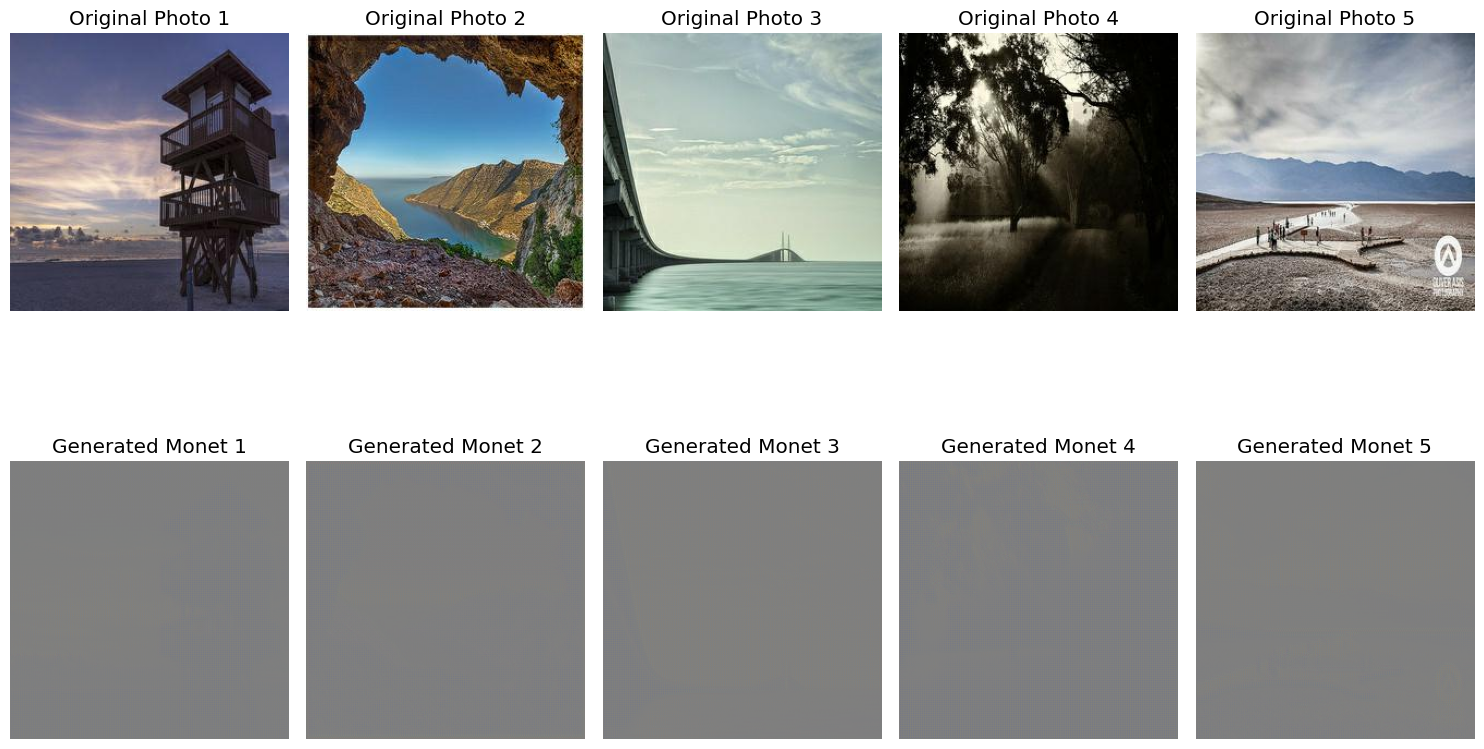

Generated images saved to ./generated_images


In [23]:
# Generate and display a few sample images
if generator_g is None:
    raise ValueError("Generator model not loaded correctly. Check the model path or checkpoint directory.")

if generator_g is not None and os.path.exists(PHOTO_JPG_DIR):
    # Get a list of photo files
    photo_files = [os.path.join(PHOTO_JPG_DIR, f) for f in os.listdir(PHOTO_JPG_DIR) if f.endswith('.jpg')]
    
    # Select a few random photos
    sample_photos = random.sample(photo_files, min(5, len(photo_files)))
    
    # Generate and display the images
    plt.figure(figsize=(15, 10))
    for i, photo_path in enumerate(sample_photos):
        # Define output path
        output_path = os.path.join(OUTPUT_DIR, f"monet_style_{os.path.basename(photo_path)}")
        
        # Generate and save the image
        generated_image = generate_and_save_images(generator_g, photo_path, output_path)
        
        # Display original photo
        plt.subplot(2, 5, i+1)
        original_img = plt.imread(photo_path)
        plt.imshow(original_img)
        plt.title(f"Original Photo {i+1}")
        plt.axis('off')
        
        # Display generated Monet-style image
        plt.subplot(2, 5, i+6)
        plt.imshow(generated_image)
        plt.title(f"Generated Monet {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Generated images saved to {OUTPUT_DIR}")
else:
    print("Cannot generate images. Either the model is not loaded or the photo directory doesn't exist.")

In [13]:
sample_image = preprocess_image(photo_files[0])
generated_sample = generator_g(tf.expand_dims(sample_image, 0), training=False)

print("Min value:", tf.reduce_min(generated_sample).numpy())
print("Max value:", tf.reduce_max(generated_sample).numpy())

Preprocessed image range: -1.0 1.0
Min value: -0.07733199
Max value: 0.076873675


## 4. Save Generated Images for Further Analysis

Let's generate a few more images and save them for analysis in the next notebook.

In [7]:
# Generate a few more images for analysis
if generator_g is not None and os.path.exists(PHOTO_JPG_DIR):
    # Get a list of photo files
    photo_files = [os.path.join(PHOTO_JPG_DIR, f) for f in os.listdir(PHOTO_JPG_DIR) if f.endswith('.jpg')]
    
    # Select a few random photos (different from the ones above)
    analysis_photos = random.sample(photo_files, min(10, len(photo_files)))
    
    print("Generating additional images for analysis...")
    for photo_path in analysis_photos:
        # Define output path
        output_path = os.path.join(OUTPUT_DIR, f"analysis_{os.path.basename(photo_path)}")
        
        # Generate and save the image
        generate_and_save_images(generator_g, photo_path, output_path)
    
    print(f"Additional images saved to {OUTPUT_DIR}")
else:
    print("Cannot generate additional images.")

Generating additional images for analysis...
Additional images saved to ./generated_images


## 5. Conclusion

In this notebook, we've loaded our trained CycleGAN generator model and used it to transform photographs into Monet-style paintings. We've generated and saved several examples for visual inspection.

In the next notebook (04b_Results_Analysis_Part2.ipynb), we'll perform a detailed qualitative analysis of these generated images and prepare our submission for the Kaggle competition.